## Identify areas in Jacksonville, FL that have the heaviest concentration of coffee shops

### IBM Data Science Specialization - Final Project

#### Prepared By Scott Brown on 5/12/2019

## Introduction

Jacksonville is one of the largest land mass cities in the U.S.  When people move to the city it's difficult to identify the areas that are most ideal for either remotely working in coffee shops or collaborating with others in a coffee shop setting. I will analyze the city and identify the areas that have the heaviest concentration of coffee shops. I have some initial expectations based on my experience with the city, but it will be interesting to see if those expectations are consistent with the results. 

## Data and Methodology

There isn't a good list of neighborhoods that is accessible for free related to Jacksonville, FL. See I retrieved a list of the zip codes in the city and the latitude and longitude coordinates for those zip codes. These were retrieved from the following website: https://www.unitedstateszipcodes.org/zip-code-database/

Then I used these coordinates to perform a 5 mile radius search of venues from the Four Square API. Using this data, I was able determine which venue categories had the highest frequency for each zip code and then identified the zip codes with Coffee Shops in their top venue categories. 

In [1]:
#Import libraries

import numpy as np 
import pandas as pd 

In [2]:
JaxZipCodes = pd.read_csv('FullZipCodeDatabase-Jax.csv')
JaxZipCodes.head()

,zip,latitude,longitude,irs_estimated_population_2015
0,32099,30.33,-81.65,0
1,32202,30.33,-81.65,2770
2,32204,30.32,-81.68,5700
3,32205,30.30,-81.72,23730
4,32206,30.35,-81.64,13360


In [3]:
#Display size of dataframe

print(JaxZipCodes.shape)

(33, 4)


## Exploratory Data Analysis

In [4]:
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

In [5]:
address = 'Jacksonville'

geolocator = Nominatim(user_agent="capstone_coursera_SB")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Jacksonville FL are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Jacksonville FL are 30.3321838, -81.655651.


In [6]:
map_jax = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(JaxZipCodes['latitude'], JaxZipCodes['longitude'], JaxZipCodes['zip']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_jax)  
    
map_jax



#### Explore Coffee Shops in Various Jacksonville Zip Codes

In [7]:
CLIENT_ID = 'D01SZLAIMCZZP4KLE5EHP4YIDRDGOJKKXCUCNTWUFP4E5VSE' # your Foursquare ID
CLIENT_SECRET = 'L3NB1OIQTKU4GKVRXASD4E5RAENKS2UIRVQBR4NP4GMRFUJ0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

LIMIT = 100

Your credentails:
CLIENT_ID: D01SZLAIMCZZP4KLE5EHP4YIDRDGOJKKXCUCNTWUFP4E5VSE
CLIENT_SECRET:L3NB1OIQTKU4GKVRXASD4E5RAENKS2UIRVQBR4NP4GMRFUJ0


In [8]:
#Create a function to pull venues for all the neighborhoods

import requests # library to handle requests

def getNearbyVenues(names, latitudes, longitudes, radius=8000):
    
    venues_list=[]

    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zip', 
                  'Zip Latitude', 
                  'Zip Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
jax_venues = getNearbyVenues(names=JaxZipCodes['zip'],
                                   latitudes=JaxZipCodes['latitude'],
                                   longitudes=JaxZipCodes['longitude']
                                  )

print(jax_venues.shape)
jax_venues.head()

32099
32202
32204
32205
32206
32207
32208
32209
32210
32211
32212
32216
32217
32218
32219
32220
32221
32222
32223
32224
32225
32226
32227
32234
32244
32246
32250
32254
32256
32257
32258
32267
32277
(2947, 7)


,Zip,Zip Latitude,Zip Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,32099,30.33,-81.65,The Florida Theatre,30.326393,-81.655704,Theater
1,32099,30.33,-81.65,Jacksonville Veterans Memorial Arena,30.325776,-81.644960,General Entertainment
2,32099,30.33,-81.65,Intuition Ale Works (Bay St),30.323364,-81.644578,Brewery
3,32099,30.33,-81.65,Jax Truckies,30.327994,-81.657088,Food Truck
4,32099,30.33,-81.65,Olio,30.325401,-81.654320,Café


In [10]:
jax_venues[jax_venues['Venue Category']=='Coffee Shop'].groupby('Venue Category').count()

,Zip,Zip Latitude,Zip Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Coffee Shop,99,99,99,99,99,99


In [11]:
#Return dataframe with coffee shop category
jax_venues_coffee = jax_venues[jax_venues['Venue Category'] == 'Coffee Shop']
jax_venues_coffee.head()

,Zip,Zip Latitude,Zip Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
6,32099,30.33,-81.65,Chamblin's Uptown,30.328552,-81.658890,Coffee Shop
21,32099,30.33,-81.65,The Brick,30.328458,-81.660795,Coffee Shop
24,32099,30.33,-81.65,Urban Grind Coffee Company,30.326413,-81.659212,Coffee Shop
53,32099,30.33,-81.65,Bold Bean Coffee,30.306463,-81.653809,Coffee Shop
106,32202,30.33,-81.65,Chamblin's Uptown,30.328552,-81.658890,Coffee Shop


In [29]:
coffee_by_zip = jax_venues_coffee[['Zip','Venue']]
coffee_by_zip.groupby('Zip').count()

,Venue
Zip,
32099,4
32202,4
32204,6
32205,5
32206,4
32207,6
32208,4
32209,5
32210,4


In [35]:
coffee_by_venue = jax_venues_coffee[['Zip','Venue']]
coffee_by_venue = coffee_by_venue.groupby('Venue').count()
coffee_by_venue = coffee_by_venue.sort_values(['Zip'],ascending=False)
coffee_by_venue

,Zip
Venue,
Starbucks,46
Bold Bean Coffee,12
Chamblin's Uptown,9
Urban Grind Coffee Company,7
The Brick,6
Vagabond Coffee Co,4
Aroma Corner,3
Ellianos Coffee Company,3
Southern Roots Filling Station,2


#### Analyze each zip code

In [14]:
# one hot encoding
jax_onehot = pd.get_dummies(jax_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
jax_onehot['Zip'] = jax_venues['Zip'] 

# move neighborhood column to the first column
fixed_columns = [jax_onehot.columns[-1]] + list(jax_onehot.columns[:-1])
jax_onehot = jax_onehot[fixed_columns]

jax_onehot = jax_onehot[['Zip','Coffee Shop']]
jax_onehot.head()

,Zip,Coffee Shop
0,32099,0
1,32099,0
2,32099,0
3,32099,0
4,32099,0


In [15]:
jax_onehot.shape

(2947, 2)

In [16]:
#Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
jax_grouped = jax_onehot.groupby('Zip').mean().reset_index()
jax_grouped.head()

,Zip,Coffee Shop
0,32099,0.04
1,32202,0.04
2,32204,0.06
3,32205,0.05
4,32206,0.04


In [17]:
jax_grouped.shape

(33, 2)

In [18]:
#Print each neighborhood and top 5 venues

num_top_venues = 5

for hood in jax_grouped['Zip']:
    print(hood)
    temp = jax_grouped[jax_grouped['Zip'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

32099
         venue  freq
0  Coffee Shop  0.04


32202
         venue  freq
0  Coffee Shop  0.04


32204
         venue  freq
0  Coffee Shop  0.06


32205
         venue  freq
0  Coffee Shop  0.05


32206
         venue  freq
0  Coffee Shop  0.04


32207
         venue  freq
0  Coffee Shop  0.06


32208
         venue  freq
0  Coffee Shop  0.04


32209
         venue  freq
0  Coffee Shop  0.05


32210
         venue  freq
0  Coffee Shop  0.04


32211
         venue  freq
0  Coffee Shop  0.04


32212
         venue  freq
0  Coffee Shop  0.05


32216
         venue  freq
0  Coffee Shop  0.04


32217
         venue  freq
0  Coffee Shop  0.05


32218
         venue  freq
0  Coffee Shop  0.03


32219
         venue  freq
0  Coffee Shop   0.0


32220
         venue  freq
0  Coffee Shop   0.0


32221
         venue  freq
0  Coffee Shop  0.01


32222
         venue  freq
0  Coffee Shop  0.01


32223
         venue  freq
0  Coffee Shop  0.03


32224
         venue  freq
0  Coffee Shop  0.03




## Results

In [23]:
#Display in descending order the zip codes with coffee shop concentrations
jax_grouped.sort_values(['Coffee Shop'],ascending=False)

,Cluster Labels,Zip,Coffee Shop
27,3,32254,0.060000
2,3,32204,0.060000
5,3,32207,0.060000
12,2,32217,0.050000
3,2,32205,0.050000
7,2,32209,0.050000
10,2,32212,0.050000
28,0,32256,0.041667
20,0,32225,0.040000
1,0,32202,0.040000


#### Cluster Neighborhoods

In [20]:
from sklearn.preprocessing import StandardScaler

# set number of clusters
kclusters = 7

jax_grouped_clustering = jax_grouped.drop('Zip', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(jax_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([0, 0, 3, 2, 0, 3, 0, 2, 0, 0])

In [21]:
# add clustering labels
jax_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

jax_merged = JaxZipCodes

# merge jax_grouped with jax_data to add latitude/longitude for each neighborhood
jax_merged = jax_merged.join(jax_grouped.set_index('Zip'), on='zip')

jax_merged.head() # check the last columns!

,zip,latitude,longitude,irs_estimated_population_2015,Cluster Labels,Coffee Shop
0,32099,30.33,-81.65,0,0,0.04
1,32202,30.33,-81.65,2770,0,0.04
2,32204,30.32,-81.68,5700,3,0.06
3,32205,30.30,-81.72,23730,2,0.05
4,32206,30.35,-81.64,13360,0,0.04


In [22]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(jax_merged['latitude'], jax_merged['longitude'], jax_merged['zip'], jax_merged['Cluster Labels']):
    cluster = np.nan_to_num(cluster)
    cluster = int(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

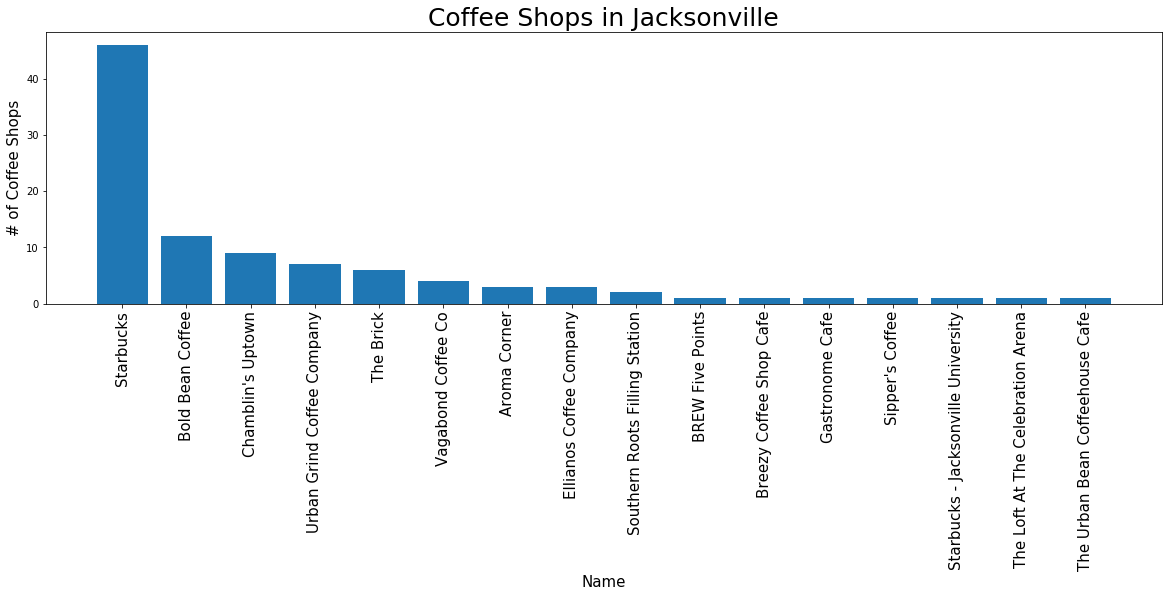

In [56]:
import matplotlib.pyplot as plt

#def plot_bar_x():
    # this is for plotting purpose
venue = coffee_by_venue.index.values
index = np.arange(len(venue))
plt.figure(figsize=(20,5))
plt.bar(index, coffee_by_venue['Zip'])
plt.xlabel('Name', fontsize=15)
plt.ylabel('# of Coffee Shops', fontsize=15)
plt.xticks(index, venue, fontsize=15, rotation=90)
plt.title('Coffee Shops in Jacksonville', fontsize=25)
plt.show()

## Conclusion



The Jacksonville zip code with the heaviest concentration of coffee shops is 32204 (Riverside), 32207 (San Marco), and 32254 (Westside). These areas are more historic and tend to attract a younger and trendy population. This result makes alot of sense given my knowledge of the city. 

The zip codes that also have a heavy concentration of coffee shops are the following:

32205 (Westside near Riverside)
32209 (North part of Downtown)
32217 (San Jose)
32212 (NAS Jax)
32225 (Intracoastal area)


Several of these make alot of sense based on my initial expectations. However, it was surprising to see the 32209 (North part of Downtown) zip code on these results. Perhaps some of the vitalization of downtown projects have encouraged growth in these areas. 

Most of these zip codes are in the more historical areas with the exception of the 32212 (NAS Jax). However, this is an area with a military base and not alot of venues, so perhaps the data is skewed because there isn't much data within that particular zip code. 


Coffee Shop Brands - 
As expected, Starbucks has the heaviest presence of coffee shops in the market. However, approximately half of the population are local coffee shops so there is plenty of local presence for anyone that's looking to avoid a national chain coffee shop. 